In [1]:
import pandas as pd

# Ruta del archivo (puedes poner el path completo o solo el nombre si está en la misma carpeta)
ruta_archivo1 = 'C:/Users/sarpalac/OneDrive - Grupo Bancolombia/SaraPalacios/ENTREGA MODELO/train.csv/train.csv'
ruta_archivo2 = 'C:/Users/sarpalac/OneDrive - Grupo Bancolombia/SaraPalacios/ENTREGA MODELO/validation.csv/validation.csv'
ruta_archivo3= 'C:/Users/sarpalac/OneDrive - Grupo Bancolombia/SaraPalacios/ENTREGA MODELO/creditcard.csv/creditcard.csv'

# Leer el CSV
train = pd.read_csv(ruta_archivo1)
validation = pd.read_csv(ruta_archivo2)
originales = pd.read_csv(ruta_archivo3)

In [ ]:
# Imported Libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

#### Analisis descriptivo y exploratorio 

In [39]:
originales['Hour'] = originales['Time'].apply(lambda x: np.floor(x / 3600))

tmp = originales.groupby(['Hour', 'Class'])['Amount'].aggregate(['min', 'max', 'count', 'sum', 'mean', 'median', 'var']).reset_index()
df = pd.DataFrame(tmp)
df.columns = ['Hour', 'Class', 'Min', 'Max', 'Transactions', 'Sum', 'Mean', 'Median', 'Var']
df.head()

,Hour,Class,Min,Max,Transactions,Sum,Mean,Median,Var
0,0.0,0,0.0,7712.43,3961,256572.87,64.774772,12.990,45615.821201
1,0.0,1,0.0,529.00,2,529.00,264.500000,264.500,139920.500000
2,1.0,0,0.0,1769.69,2215,145806.76,65.826980,22.820,20053.615770
3,1.0,1,59.0,239.93,2,298.93,149.465000,149.465,16367.832450
4,2.0,0,0.0,4002.88,1555,106989.39,68.803466,17.900,45355.430437


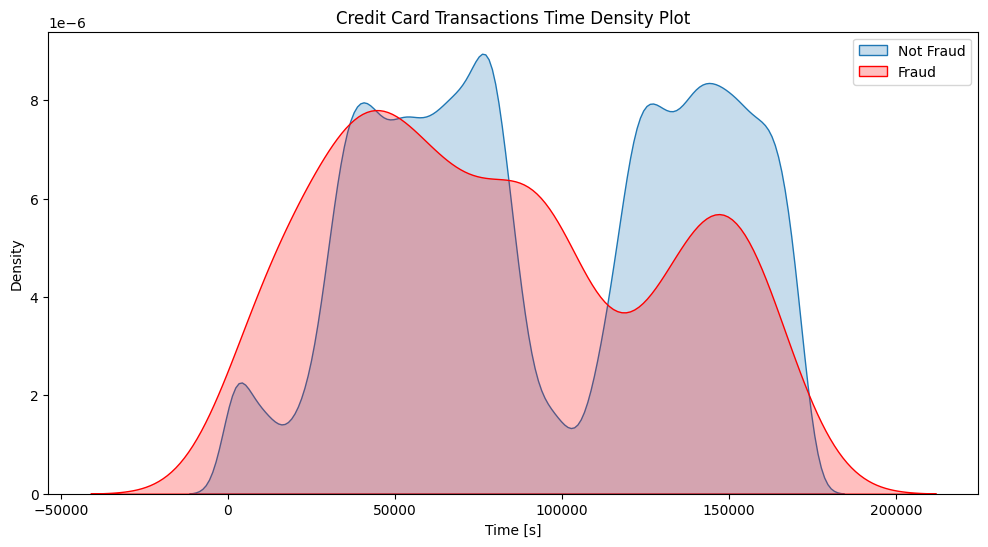

In [3]:

class_0 = originales.loc[originales['Class'] == 0]["Time"]
class_1 = originales.loc[originales['Class'] == 1]["Time"]

plt.figure(figsize=(12,6))
sns.kdeplot(class_0, label='Not Fraud', fill=True)
sns.kdeplot(class_1, label='Fraud', fill=True, color='red')
plt.title('Credit Card Transactions Time Density Plot')
plt.xlabel('Time [s]')
plt.legend()
plt.show()

Eje X: Time [s] — El tiempo (en segundos) desde el inicio de la recopilación de datos.

Eje Y: Density — Densidad (probabilidad relativa de ocurrencia en cada rango de tiempo).

Curva azul: Transacciones no fraudulentas (Not Fraud)

Curva roja: Transacciones fraudulentas (Fraud)

##### Interpretación 
Patrones de comportamiento diferentes:
Las distribuciones para fraude y no fraude no son idénticas. Hay momentos del día (o de la ventana de muestreo) en que el fraude es relativamente más frecuente que el resto del tiempo.

- Las picos muestran horas en las que hay más transacciones.

- El fraude ocurre con más frecuencia relativa en ciertos periodos. Indicando que el riesgo de fraude es más alto en esos momentos.

- También se observa que las curvas coinciden, la probabilidad de fraude es similar a la de una transacción común en ese periodo.

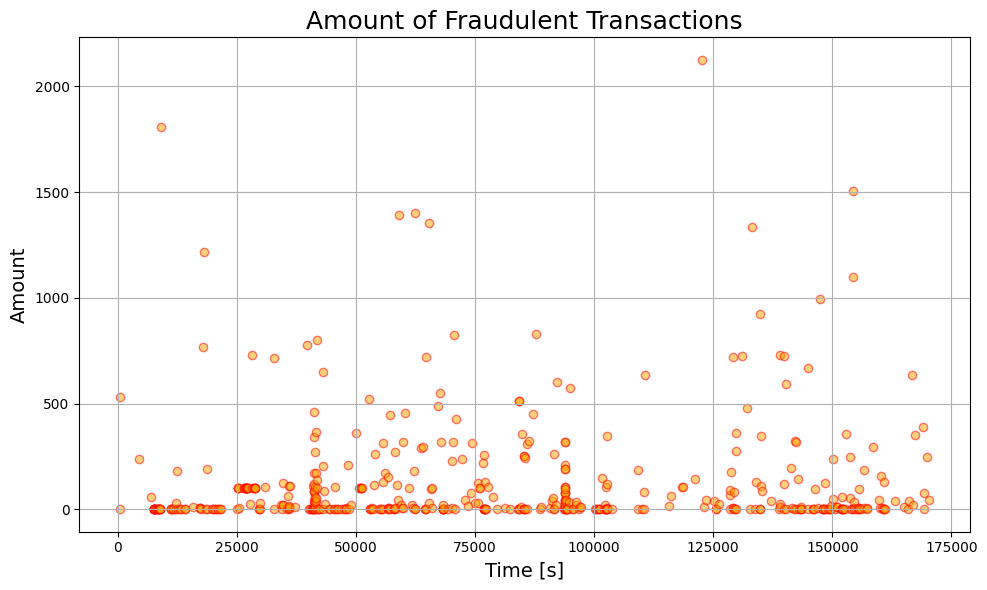

In [ ]:
fraud = originales[originales['Class'] == 1]

# Asumiendo que 'fraud' ya está definido como originales[originales['Class'] == 1]

plt.figure(figsize=(10,6))
plt.scatter(fraud['Time'], fraud['Amount'], 
            color='orange', edgecolor='red', alpha=0.5)

plt.title('Amount of Fraudulent Transactions', fontsize=18)
plt.xlabel('Time [s]', fontsize=14)
plt.ylabel('Amount', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


X: Time [s] (segundos desde el inicio del registro de transacciones)

Y: Amount (valor monetario de cada transacción)

Puntos: Cada punto es una transacción que corresponde a transacciones fraudulentas.

#### Conclusiones
- No hay una tendencia clara en el tiempo

- Los fraudes ocurren a lo largo de todo el rango de tiempo, no están concentrados en una ventana específica del día.

- No se observan concentraciones temporales donde el fraude sea más intenso.

- La mayoría de los fraudes involucran montos pequeños

-  mayor concentración de puntos está cerca de valores bajos de Amount (menores a 500).

La mayoría de las transacciones fraudulentas involucran montos pequeños, lo cual es consistente con patrones típicos de fraude (para evadir detección).

Existen fraudes de montos altos, pero son menos frecuentes

Hay algunos outliers (puntos aislados arriba de 1000, incluso cerca de 2000 o más).

Conclusión: Aunque poco frecuentes, existen intentos de fraude con montos significativamente altos.


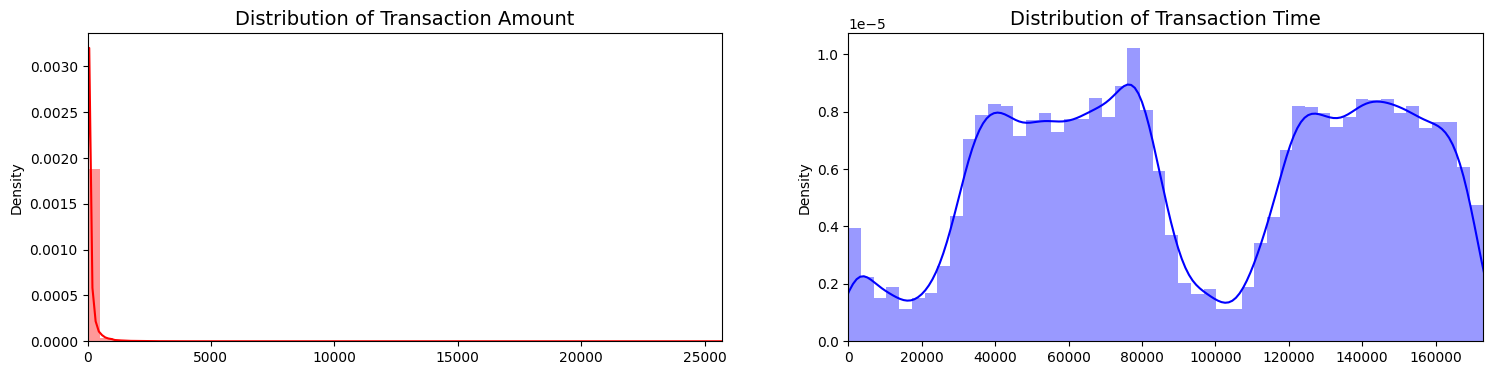

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = originales['Amount'].values
time_val = originales['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val, ax=ax[1], color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])



plt.show()

#### Izquierda: Distribution of Transaction Amount
- La gran mayoría de las transacciones tienen un monto bajo.

- La curva es extremadamente alta cerca de 0 y cae rápidamente.

Conclusión: El grueso de las transacciones (fraudulentas o no, según la base mostrada) corresponde a montos pequeños, por debajo de 500 o incluso menos.

- Hay pocos valores altos (outliers).

- El eje X llega hasta 25,000, pero la densidad ahí es prácticamente cero.

Conclusión: Las transacciones de gran valor son muy raras y atípicas. Esto es típico en bases reales: muchas transacciones pequeñas, pocas muy grandes.

#### Derecha: Distribution of Transaction Time
- La distribución del tiempo no es uniforme.

- Se observan dos “picos” principales y una caída clara al centro, en torno a 90,000-100,000.

Conclusión: Hay dos intervalos de tiempo en el día (o ciclo de registro) donde ocurren más transacciones; podría deberse a horarios pico (por ejemplo, en la mañana y la tarde), y una baja actividad en la mitad del ciclo (probablemente en la madrugada).

- No hay evidencia de concentración extrema en un solo periodo.

- Aunque hay picos, la actividad es significativa en varios momentos, no solo en un horario.

Conclusión: No hay “ventanas únicas” para la actividad transaccional, pero sí hay horarios preferidos.

#### Conclusión general 

La mayoría de las transacciones son de bajo monto, con muy pocos eventos de alto valor. En cuanto al tiempo, la actividad no está distribuida uniformemente, sino que existen al menos dos periodos bien definidos de mayor transacción, probablemente asociados a los horarios de mayor actividad del comercio o la banca. Estos patrones son importantes para ajustar reglas de monitoreo de fraude, establecer umbrales de alerta por horario y entender el comportamiento típico del sistema.

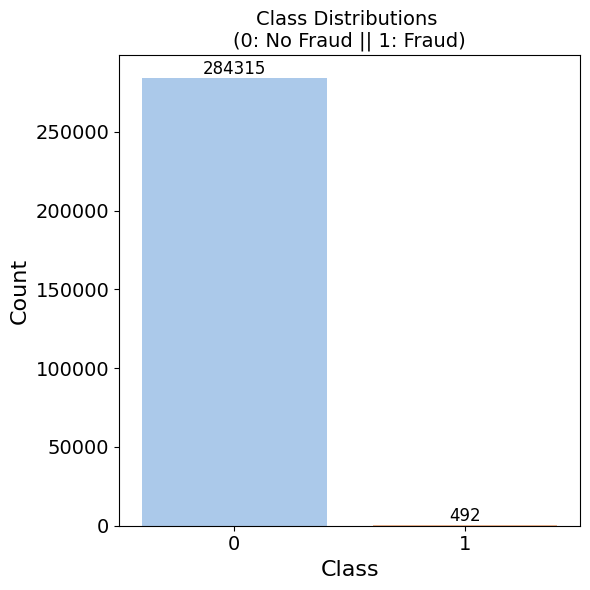

In [38]:
plt.figure(figsize=(6, 6))  # Cambia los valores para más ancho y alto
ax = sns.countplot(x='Class', data=originales, palette="pastel")
plt.title('Class Distributions \n(0: No Fraud || 1: Fraud)', fontsize=14)

# Etiquetas encima de las barras
for p in ax.patches:
    count = int(p.get_height())
    ax.annotate(f'{count}', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=12, color='black')

plt.xlabel('Class', fontsize=16)
plt.ylabel('Count', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()  # Para que no se corte nada
plt.show()


#### Preparación modelo

Distribution of the Classes in the subsample dataset
class
0    0.5
1    0.5
Name: count, dtype: float64


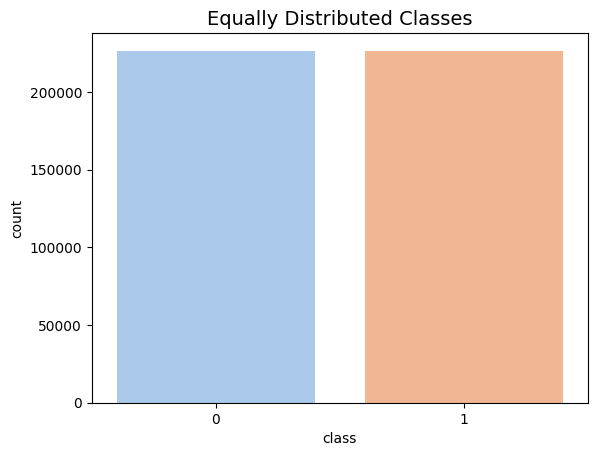

In [8]:

print('Distribution of the Classes in the subsample dataset')
print(train['class'].value_counts()/len(train))



sns.countplot(x='class', data=train, palette="pastel")
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


In [9]:
X_train = train.drop('class', axis=1)
y_train = train['class']
X_val = validation.drop('class', axis=1)
y_val = validation['class']

#### Definir y entrenar modelo 

In [10]:
from sklearn.ensemble import RandomForestClassifier

# Parámetros recomendados
N_JOBS = 4          # Todos los núcleos disponibles
RANDOM_STATE = 42     # Puedes cambiar por cualquier número fijo
CRITERION = 'gini'    # O 'entropy'
N_ESTIMATORS = 80    # Número de árboles

clf = RandomForestClassifier(
    n_jobs=N_JOBS,
    random_state=RANDOM_STATE,
    criterion=CRITERION,
    n_estimators=N_ESTIMATORS,
    verbose=False
)

clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=80, n_jobs=4, random_state=42,
                       verbose=False)

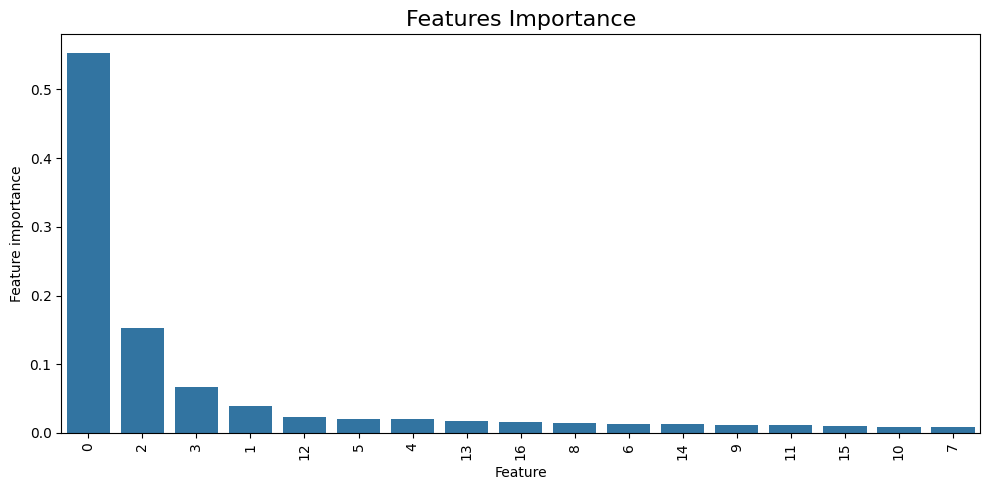

In [11]:
preds = clf.predict(X_val)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crea un DataFrame de la importancia de las variables
tmp = pd.DataFrame({
    'Feature': X_train.columns,
    'Feature importance': clf.feature_importances_
})
tmp = tmp.sort_values('Feature importance', ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x='Feature', y='Feature importance', data=tmp)
plt.title('Features Importance', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


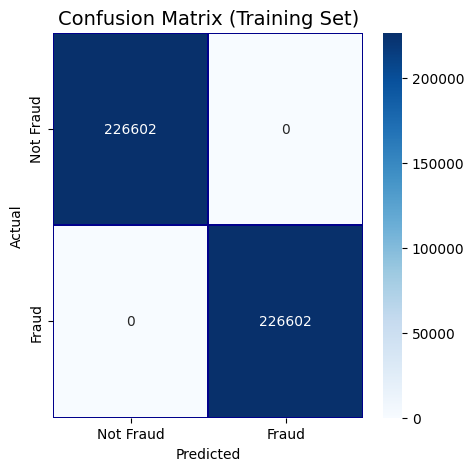

In [12]:
# Asumiendo que clf ya está entrenado
train_preds = clf.predict(X_train)
val_preds = clf.predict(X_val)


# Para entrenamiento
cm = pd.crosstab(y_train, train_preds, rownames=['Actual'], colnames=['Predicted'])

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm,
    xticklabels=['Not Fraud', 'Fraud'],
    yticklabels=['Not Fraud', 'Fraud'],
    annot=True, fmt='d',
    ax=ax,
    linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (Training Set)', fontsize=14)
plt.show()


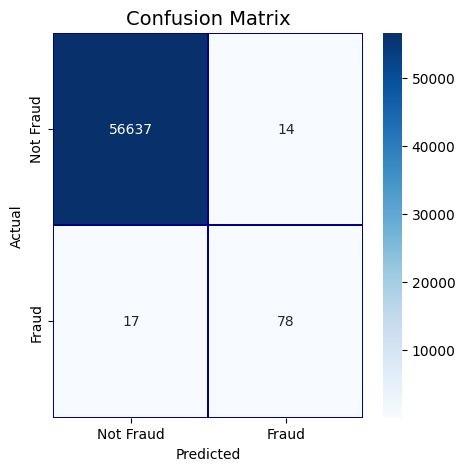

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Crea la matriz de confusión
cm = pd.crosstab(y_val, preds, rownames=['Actual'], colnames=['Predicted'])

fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, fmt='d', 
            ax=ax,
            linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix', fontsize=14)
plt.show()


In [14]:
from sklearn.metrics import classification_report, average_precision_score, precision_recall_curve

print(classification_report(y_val, preds))

# Para AUC-PR
probas = clf.predict_proba(X_val)[:,1]
auc_pr = average_precision_score(y_val, probas)
print("AUC-PR:", auc_pr)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.85      0.82      0.83        95

    accuracy                           1.00     56746
   macro avg       0.92      0.91      0.92     56746
weighted avg       1.00      1.00      1.00     56746

AUC-PR: 0.8099563941838588


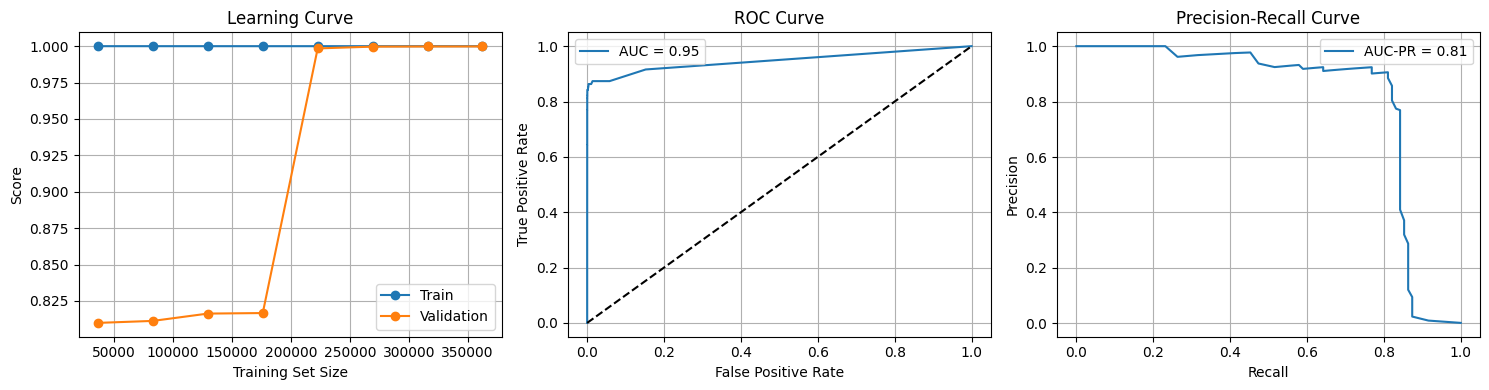

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# 1. CURVA DE APRENDIZAJE
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf,
    X=X_train,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',  # Puedes cambiar a 'recall', 'f1', etc.
    n_jobs=-1
)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

# 2. CURVA ROC
y_proba = clf.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# 3. CURVA PRECISION-RECALL
precision, recall, _ = precision_recall_curve(y_val, y_proba)
auc_pr = average_precision_score(y_val, y_proba)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


#### Conclusiones del Modelo Random Forest (80 árboles)
 Curva de aprendizaje (Learning Curve)
La curva de entrenamiento está cerca de 1.0 (score perfecto), lo que indica que el modelo aprende perfectamente sus datos de entrenamiento.

La curva de validación sube rápidamente y se estabiliza cerca de 1.0 cuando el set de entrenamiento crece, mostrando que el modelo generaliza bien al conjunto de validación.

No hay un gap grande entre ambas curvas → No hay sobreajuste fuerte.
 
 
#### Curva ROC y Curva Precision-Recall
AUC ROC ≈ 0.95: Excelente capacidad de discriminación para separar fraudes vs. no fraudes. Un modelo aleatorio tendría AUC de 0.5.

AUC-PR ≈ 0.81: Bastante bueno, especialmente considerando que el set de validación está desbalanceado (muchas más transacciones legítimas que fraudulentas).

Conclusión: El modelo tiene buen rendimiento en ambos indicadores clave para problemas desbalanceados, detecta la mayoría de fraudes (82%) y comete pocos falsos positivos (14). Son valores muy sólidos para un problema de fraude.

#### Modelo 2

In [28]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
clf1 = DecisionTreeClassifier(
    random_state=42,
    criterion='gini',
    max_depth=40
)


clf1.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=40, random_state=42)

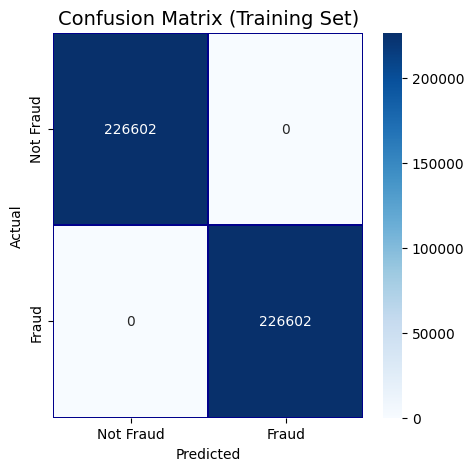

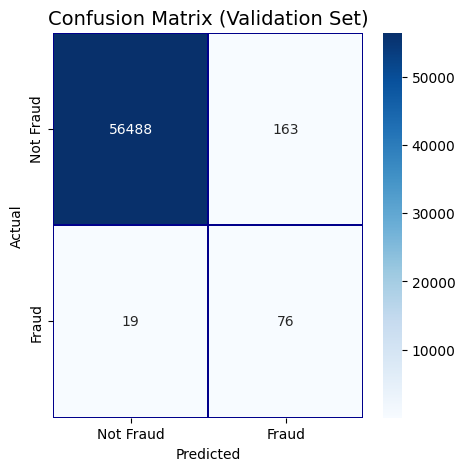

In [29]:
# Predicciones
train_preds = clf1.predict(X_train)
val_preds = clf1.predict(X_val)

# Matriz de confusión para entrenamiento
cm_train = pd.crosstab(y_train, train_preds, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_train, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, fmt='d', 
            ax=ax, linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (Training Set)', fontsize=14)
plt.show()

# Matriz de confusión para validación
cm_val = pd.crosstab(y_val, val_preds, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_val, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, fmt='d', 
            ax=ax, linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (Validation Set)', fontsize=14)
plt.show()


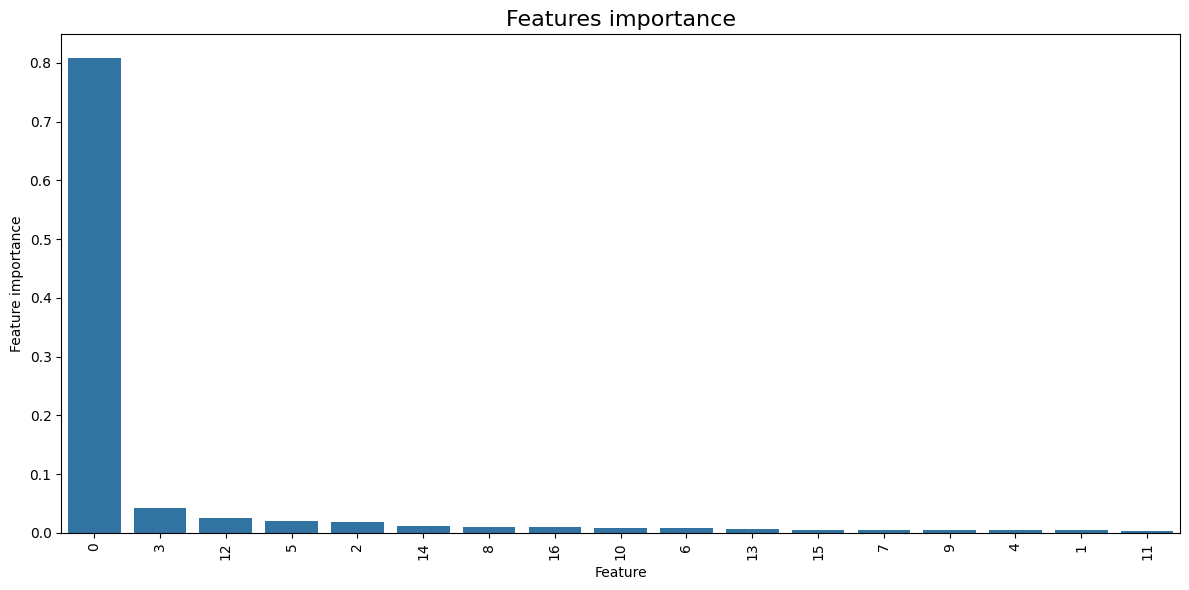

In [30]:
tmp = pd.DataFrame({
    'Feature': X_train.columns,
    'Feature importance': clf1.feature_importances_
}).sort_values(by='Feature importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='Feature', y='Feature importance', data=tmp)
plt.title('Features importance', fontsize=16)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


In [31]:
from sklearn.metrics import classification_report, average_precision_score

print(classification_report(y_val, val_preds))

probas = clf1.predict_proba(X_val)[:, 1]
auc_pr = average_precision_score(y_val, probas)
print("AUC-PR:", auc_pr)


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56651
           1       0.32      0.80      0.46        95

    accuracy                           1.00     56746
   macro avg       0.66      0.90      0.73     56746
weighted avg       1.00      1.00      1.00     56746

AUC-PR: 0.2547281308014706


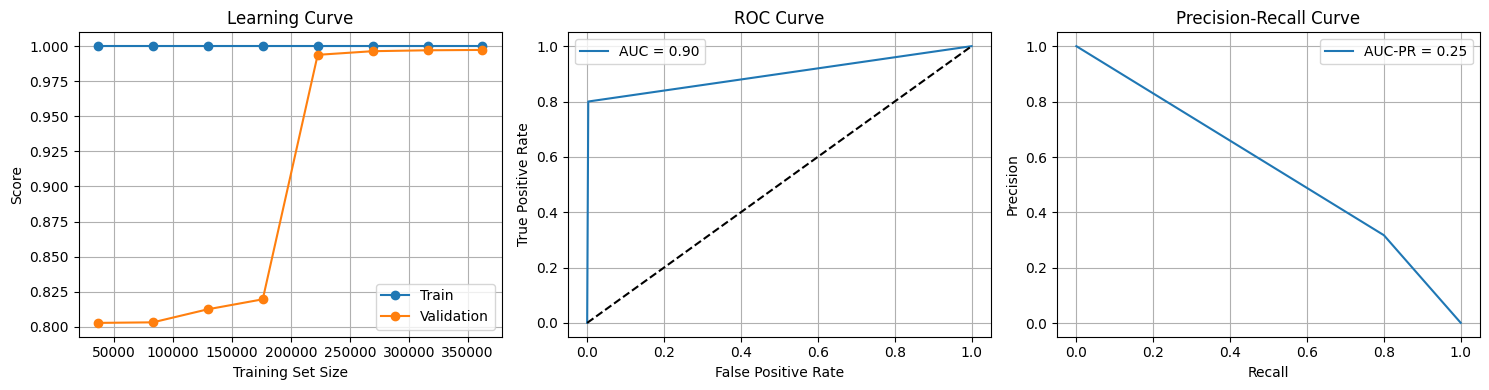

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# === 1. CURVA DE APRENDIZAJE ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf1,
    X=X_train,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',      # Cambia por 'recall', 'f1', etc, si prefieres otra métrica
    n_jobs=-1
)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

# === 2. CURVA ROC ===
# Si tu problema es binario, DecisionTreeClassifier sí tiene predict_proba:
y_proba = clf1.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# === 3. CURVA PRECISIÓN-RECALL ===
precision, recall, _ = precision_recall_curve(y_val, y_proba)
auc_pr = average_precision_score(y_val, y_proba)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


El modelo tiene un overfitting extremo. El árbol de decisión (profundidad 40)(se obtiene el mismo resultado con diferentes profundidades) predice perfectamente en el set de entrenamiento, pero pierde capacidad en validación.

El dataset de validación está fuertemente desbalanceado. Hay muchísimos más "no fraudes" que "fraudes", lo que afecta gravemente la utilidad de métricas clásicas como accuracy y hasta el ROC. AUC-PR es la métrica crítica en estos casos, y es baja (0.25).

El modelo logra recall decente para fraudes (0.80), pero la precisión para fraudes es muy baja (0.32): de cada 100 que predice como fraude, solo ~32 son verdaderamente fraude. Habrá muchas falsas alarmas.



## Moedelo 3

In [42]:
from sklearn.linear_model import LogisticRegression

# Entrenamiento (ajusta el parámetro class_weight si tus datos están desbalanceados)
clf4 = LogisticRegression(
    random_state=42,
    max_iter=500,                # Puedes aumentarlo si da warning de convergencia
    class_weight='balanced'      # Útil si la clase minoritaria es importante
)
clf4.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', max_iter=500, random_state=42)

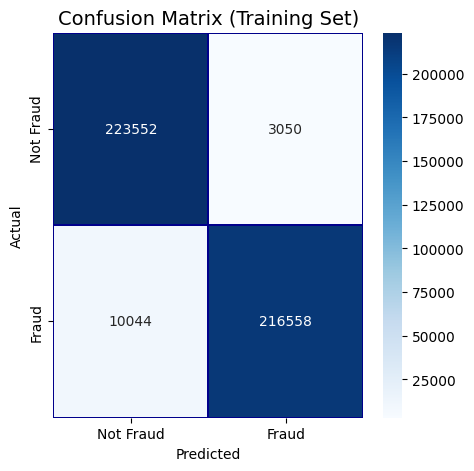

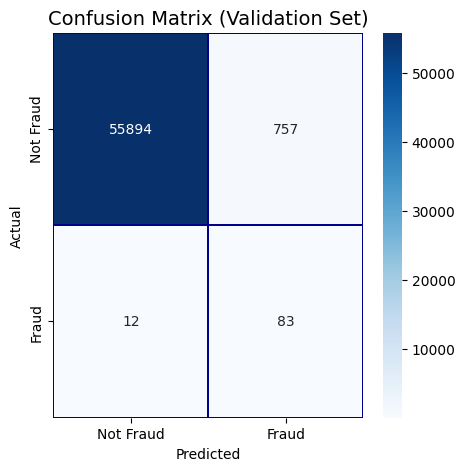

In [43]:
# Predicciones
train_preds = clf4.predict(X_train)
val_preds = clf4.predict(X_val)

# Matriz de confusión para entrenamiento
cm_train = pd.crosstab(y_train, train_preds, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_train, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, fmt='d', 
            ax=ax, linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (Training Set)', fontsize=14)
plt.show()

# Matriz de confusión para validación
cm_val = pd.crosstab(y_val, val_preds, rownames=['Actual'], colnames=['Predicted'])
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(cm_val, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True, fmt='d', 
            ax=ax, linewidths=.2, linecolor="Darkblue", cmap="Blues")
plt.title('Confusion Matrix (Validation Set)', fontsize=14)
plt.show()


In [45]:
from sklearn.metrics import classification_report, average_precision_score

print(classification_report(y_val, val_preds))

probas = clf4.predict_proba(X_val)[:, 1]
auc_pr = average_precision_score(y_val, probas)
print("AUC-PR:", auc_pr)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56651
           1       0.10      0.87      0.18        95

    accuracy                           0.99     56746
   macro avg       0.55      0.93      0.59     56746
weighted avg       1.00      0.99      0.99     56746

AUC-PR: 0.7874801595435167


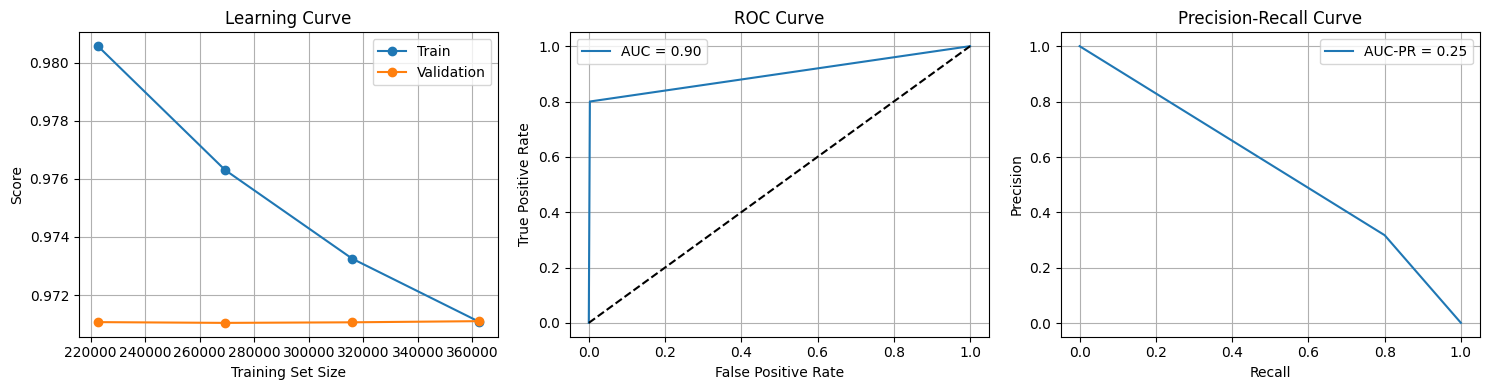

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, average_precision_score

# === 1. CURVA DE APRENDIZAJE ===
train_sizes, train_scores, val_scores = learning_curve(
    estimator=clf4,
    X=X_train,
    y=y_train,
    cv=5,
    train_sizes=np.linspace(0.1, 1.0, 8),
    scoring='accuracy',      # Cambia por 'recall', 'f1', etc, si prefieres otra métrica
    n_jobs=-1
)

plt.figure(figsize=(15,4))

plt.subplot(1,3,1)
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend()
plt.grid(True)

# === 2. CURVA ROC ===
# Si tu problema es binario, DecisionTreeClassifier sí tiene predict_proba:
y_proba = clf1.predict_proba(X_val)[:,1]
fpr, tpr, _ = roc_curve(y_val, y_proba)
auc_score = roc_auc_score(y_val, y_proba)

plt.subplot(1,3,2)
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)

# === 3. CURVA PRECISIÓN-RECALL ===
precision, recall, _ = precision_recall_curve(y_val, y_proba)
auc_pr = average_precision_score(y_val, y_proba)

plt.subplot(1,3,3)
plt.plot(recall, precision, label=f'AUC-PR = {auc_pr:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


- El modelo de regresión logística captura la mayoría de fraudes (alto recall) pero tiene una muy baja precisión, es decir, genera muchos falsos positivos.

- La exactitud global (accuracy) es engañosa debido al fuerte desbalance de clases.

- El modelo sufre de underfitting: ni siquiera logra alto desempeño de validación aunque se aumente la muestra de entrenamiento.

- La métrica más relevante (AUC-PR) es baja: el modelo no es bueno para discriminar fraudes de no fraudes en la práctica.

#### Comparado con Random Forest y Decision Tree:

La regresión logística tiene peor desempeño, especialmente en precisión y f1-score para la clase fraudulenta.

Los modelos de árbol lograron mejor balance entre precisión y recall para fraude (con ajustes), aunque también presentaron limitaciones por el desbalance.



#### Conclusión final 


- El mejor modelo es claramente el Random Forest.

- Tiene el mejor balance entre precisión y recall para la clase de fraude, con un F1-score alto (0.83), y el mejor macro F1.

- El AUC-PR (0.81) indica que el modelo tiene buen desempeño en la clase minoritaria.

- Los otros modelos o bien tienen muy mala precisión (muchos falsos positivos) o bajo F1-score.

¿Por qué no elegir los otros?
Árbol de decisión: Aunque tiene buen recall, su precisión es muy baja (muchos falsos positivos) y el AUC-PR es malo.

Regresión logística: Tiene aún peor precisión para fraudes (solo el 10% de los "fraudes" predichos son reales).


##### Se elije Random Forest para detección de fraude, basado en métricas de desempeño en la clase minoritaria, robustez, y balance general.